<a href="https://www.kaggle.com/code/eslam200/torch-audio-course?scriptVersionId=144004970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* Torch Audio Playlist - https://www.youtube.com/playlist?list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm
* Course Slides  - https://github.com/musikalkemist/pytorchforaudio/blob/main/01%20Course%20overview/PyTorch%20for%20Audio%20and%20Music%20Processing.pdf
* Kaggle Notebook - https://www.kaggle.com/code/eslam200/torch-audio-course

### What is torchaudio?
* Audio processing library for PyTorch
* I/O functionalities
* Audio datasets
* Data Augmentation
* Feature Extraction

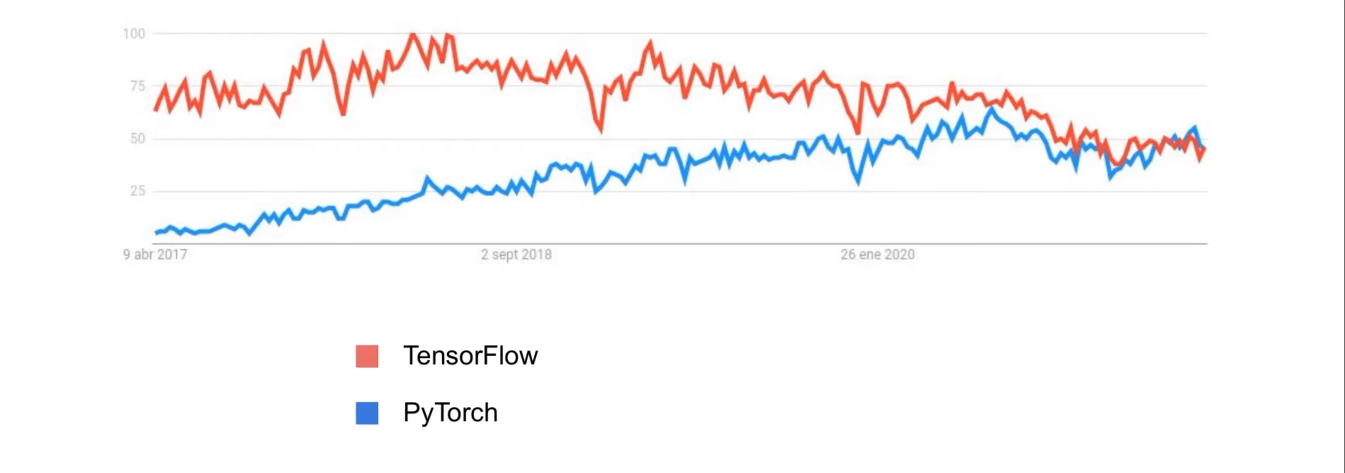
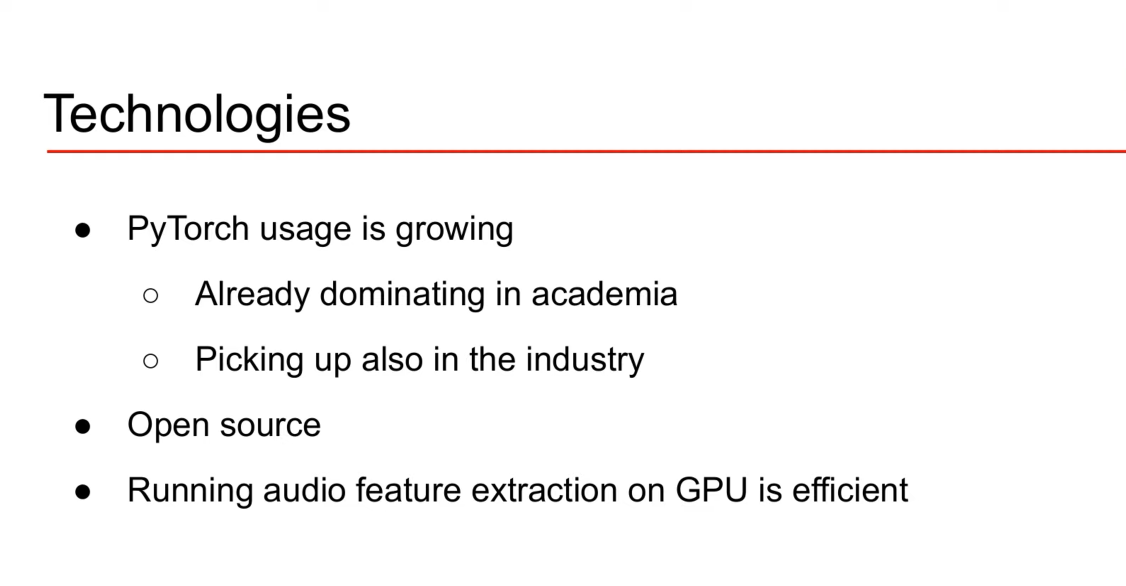

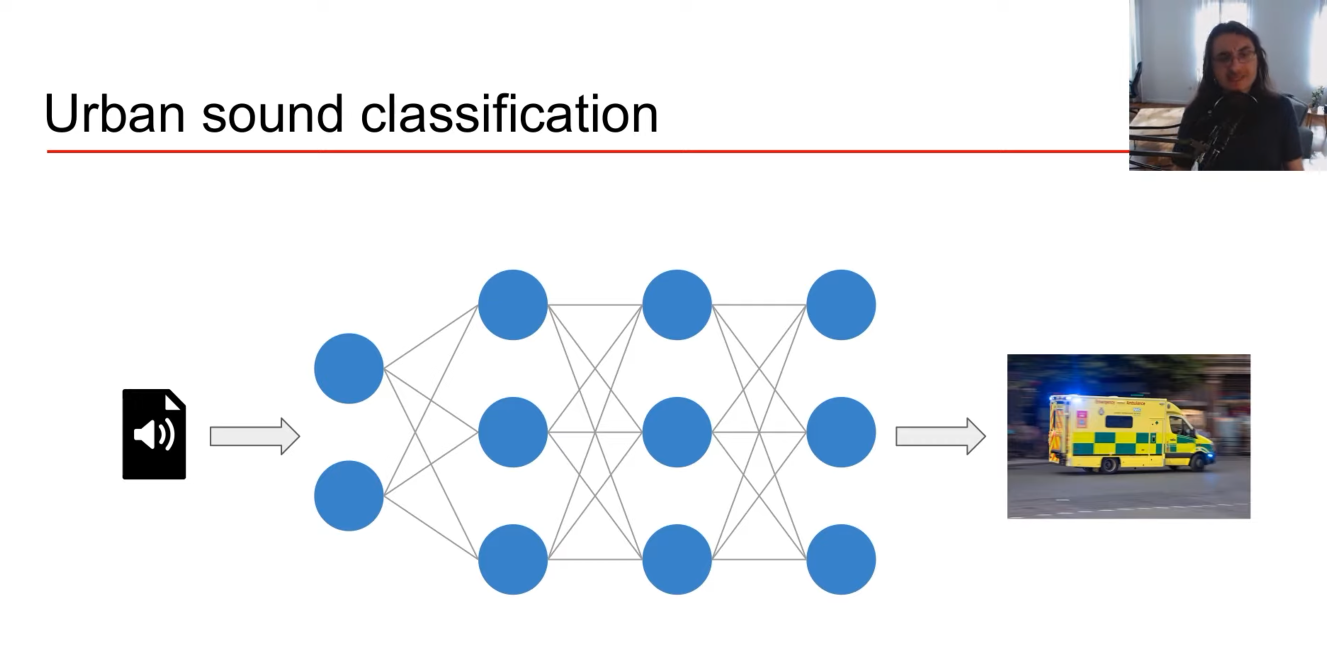

### Urban sound Classification
* Multiclass Classification problem
* UrbanSound8k Dataset
* 10 sound classes

# Implementing and Training a Neural Network

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Dowloading dataset

In [ ]:
def download_mnist_datasets():
    train_dataset = datasets.MNIST(root='data' , download=True , train = True , transform=ToTensor())
    val_dataset = datasets.MNIST(root='data' , download=True , train = False , transform=ToTensor()) 
    return train_dataset , val_dataset

In [ ]:
train_dataset , test_dataset = download_mnist_datasets()

## Creating dataloaders

In [ ]:
BATCH_SIZE = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
)

val_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
)

## Build model

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_layers = nn.Sequential(
            nn.Linear(28*28 , 256),
            nn.ReLU(),
            nn.Linear(256 , 10)
        )
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self , input_data):
        flattened_data = self.flatten(input_data)
        logits = self.dense_layers(flattened_data)
        predictions = self.softmax(logits)
        return predictions

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using {device} Device")
feed_forward_net = FeedForwardNet().to(device)

## Train

In [ ]:
def train_one_epoch(model , dataloader , loss_fn , optimizer , device):
    for inputs , targets in dataloader:
        inputs , targets = inputs.to(device) , targets.to(device)
        
        # Calculating loss
        predictions = model(inputs)
        loss = loss_fn(predictions , targets)
        
        # Backpropagate Loss and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Updating the weights
        
    print(f'Loss: {loss.item()}')
    

def train(model , dataloader , loss_fn , optimizer , device , epochs):
    for i in range(epochs):
        print(f"Epochs: {i+1}")
        train_one_epoch(model , dataloader , loss_fn , optimizer , device)
        print("-----------------------------------")
    print("Training Done")
    

In [ ]:
EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
OPTIMISER = torch.optim.Adam(feed_forward_net.parameters() , lr = LEARNING_RATE)

train(feed_forward_net , train_dataloader , LOSS_FN , OPTIMISER , device , EPOCHS)

## Save trained model

In [ ]:
torch.save(feed_forward_net.state_dict() , 'feed_forward_net.pth')
print("Model trained and stored at feed_forward_net.pth")

## Make Predictions

In [ ]:
class_mapping = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

In [ ]:
def predict(model , inputs , target , class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(inputs) # (inputs , num_classes)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted , expected

In [ ]:
feed_forward_net = FeedForwardNet()
state_dict = torch.load('feed_forward_net.pth')
feed_forward_net.load_state_dict(state_dict)

validation_dataset = test_dataset

# Getting a sample from the validation dataset fotr inference
inputs , targets = validation_dataset[0][0] , validation_dataset[0][1]

# Make an inference
predicted , expected = predict(feed_forward_net , inputs , targets , class_mapping)

print(f"Predicted: {predicted}, Expected: {expected}")

# Torch Audio
* UrbanSound Dataset - https://urbansounddataset.weebly.com/urbansound8k.html
* Kaggle Notebook(UrbanSound8K Classification) - https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification
* Torchaudio.backend Docs - https://pytorch.org/audio/stable/backend.html

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import os

class UrbanSoundDataset(Dataset):
    def __init__(self , annotations_filepath , audio_dir):
        self.annotations = pd.read_csv(annotations_filepath)
        self.audio_dir = audio_dir
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal , sr = torchaudio.load(audio_sample_path)
        return signal , label
    
    def _get_audio_sample_path(self,index):
        fold = f"fold{self.annotations.iloc[index , 5]}"
        path = os.path.join(self.audio_dir , fold , self.annotations.iloc[index , 0])
        return path
    
    def _get_audio_sample_label(self , index):
        return self.annotations.iloc[index , 6]

In [ ]:
ANNOTATIONS_FILEPATH = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_DIR = "/kaggle/input/urbansound8k"
usd = UrbanSoundDataset(ANNOTATIONS_FILEPATH , AUDIO_DIR)
print(f"There are {len(usd)} samples in the dataset.")
signal , label = usd[0]

## Extracting Mal Spectrograms

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import os
import torch

class UrbanSoundDataset(Dataset):
    def __init__(self , annotations_filepath , audio_dir , transformation , target_sample_rate,num_samples , device):
        self.device = device
        self.annotations = pd.read_csv(annotations_filepath)
        self.audio_dir = audio_dir
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal , sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        # signal -> (num_channels ,samples) -> (2, 16000) -> (1,16000)
        signal = self._resmaple_if_necessary(signal , sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal , label
    
    def _get_audio_sample_path(self,index):
        fold = f"fold{self.annotations.iloc[index , 5]}"
        path = os.path.join(self.audio_dir , fold , self.annotations.iloc[index , 0])
        return path
    
    def _get_audio_sample_label(self , index):
        return self.annotations.iloc[index , 6]
    
    def _resmaple_if_necessary(self,signal , sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr , self.target_sample_rate).to(device)
            signal = resampler(signal)
        return signal
    
    def _mix_down_if_necessary(self,signal):
        if signal.shape[0] > 1:  
            signal = torch.mean(signal , dim = 0 , keepdim = True)
        return signal
    
    def _cut_if_necessary(self,signal):
        # signal -> Tensor -> (num_of_channels = 1, num_samples = 50000)
        if signal.shape[1] > self.num_samples:
            signal = signal[: , :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self , signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            # [1 , 1 , 1] -> [1 , 1 , 1 , 0 ,0]
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0 , num_missing_samples) # (0 , 2)
            signal = torch.nn.functional.pad(signal , last_dim_padding)
        return signal

In [ ]:
ANNOTATIONS_FILEPATH = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_DIR = "/kaggle/input/urbansound8k"
SAMPLE_RATE = 16000
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using Device {device}")

mal_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

usd = UrbanSoundDataset(ANNOTATIONS_FILEPATH , AUDIO_DIR , mal_spectrogram , SAMPLE_RATE , NUM_SAMPLES , device)
print(f"There are {len(usd)} samples in the dataset.")
signal , label = usd[0]

# CNN For Sound Classification

In [ ]:
# !pip install torchsummary

import torch
from torch import nn
from torchsummary import summary

class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 Conv Blocks / Flatten / Linear / Softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1 , out_channels = 16, kernel_size = 3,stride= 1 , padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16 , out_channels = 32, kernel_size = 3,stride= 1 , padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 32 , out_channels = 64, kernel_size = 3,stride= 1 , padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 64 , out_channels = 128, kernel_size = 3,stride= 1 , padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 4 , 10)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self , input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)     
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
cnn = CNNNetwork()
summary(cnn.to(device) , (1 ,64, 44))

## Training the model

In [ ]:
import torchaudio

In [ ]:
def train_one_epoch(model , dataloader , loss_fn , optimizer , device):
    for inputs , targets in dataloader:
        inputs , targets = inputs.to(device) , targets.to(device)
        model = model.to(device)
        # Calculating loss
        predictions = model(inputs)
        loss = loss_fn(predictions , targets)
        
        # Backpropagate Loss and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Updating the weights
        
    print(f'Loss: {loss.item()}')
    

def train(model , dataloader , loss_fn , optimizer , device , epochs):
    for i in range(epochs):
        print(f"Epochs: {i+1}")
        train_one_epoch(model , dataloader , loss_fn , optimizer , device)
        print("-----------------------------------")
    print("Training Done")

In [ ]:
ANNOTATIONS_FILEPATH = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_DIR = "/kaggle/input/urbansound8k"
SAMPLE_RATE = 16000
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using Device {device}")

mal_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

usd = UrbanSoundDataset(ANNOTATIONS_FILEPATH , AUDIO_DIR , mal_spectrogram , SAMPLE_RATE , NUM_SAMPLES , device)
print(f"There are {len(usd)} samples in the dataset.")
signal , label = usd[0]

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128

train_dataloader = DataLoader(
    usd,
    batch_size = BATCH_SIZE,
)

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.001

cnn = CNNNetwork()

LOSS_FN = nn.CrossEntropyLoss()
OPTIMISER = torch.optim.Adam(cnn.parameters() , lr = LEARNING_RATE)

train(cnn , train_dataloader , LOSS_FN , OPTIMISER , device , EPOCHS)

In [ ]:
torch.save(cnn.state_dict() , 'audio_cls.pth')
print("Model trained and stored at audio_cls.pth")

## Predicting

In [ ]:
class_mapping = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

In [ ]:
def predict(model , inputs , target , class_mapping):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(inputs) # (inputs , num_classes)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted , expected

In [ ]:
cnn = CNNNetwork()
state_dict = torch.load('audio_cls.pth')
cnn.load_state_dict(state_dict)

# Getting a sample from the validation dataset fotr inference
inputs , targets = usd[0][0] , usd[0][1]
inputs.unsqueeze_(dim = 0)

# Make an inference
predicted , expected = predict(cnn , inputs , targets , class_mapping)

print(f"Predicted: {predicted}, Expected: {expected}")